### Enforcing Fairness in CelebA

This code demonstrates how to enforce fairness when working with deep neural networks in computer vision. Specifically we demonstrate how different notions of fairness and performance can be measured and enforced with our toolkit.

The protected attribute is Male. The user can specify what target attribute (e.g., Wearing_Earrings) that they would like to consider. 

In [1]:
import numpy as np 
import oxonfair
from oxonfair.utils import group_metrics as gm
from matplotlib import pyplot as plt

In [2]:
def get_all_celeba_attributes():
    return ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
            'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
            'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
            'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
            'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

In [3]:
# val = np.load('prototyping_outputs_val.npy')
# val_target = np.load('prototyping_target_label_val.npy')
# val_groups = np.load('prototyping_protected_label_val.npy')

# test = np.load('prototyping_outputs_test.npy')
# test_target = np.load('prototyping_target_label_test.npy')
# test_groups = np.load('prototyping_protected_label_test.npy')

In [4]:
validation_labels = np.load('all_attributes_val_labels.npy') #loading the validation labels for all attributes
test_labels = np.load('all_attributes_test_labels.npy') #loading the test labels for all attributes

validation_outputs = np.load('All_Attributes_outputs_val.npy') # loading the corresponding outputs 
test_outputs = np.load('All_Attributes_outputs_test.npy')

In [5]:
np.column_stack((validation_outputs[:,34], validation_outputs[:,20]))

array([[-3.72390795, -0.04863382],
       [-6.71334314,  1.003914  ],
       [-5.54749012,  0.01078447],
       ...,
       [-1.99252629, -0.03643667],
       [ 0.69160038, -0.02428942],
       [-4.78321409,  0.98419327]])

(array([4.000e+00, 8.000e+00, 1.800e+01, 8.900e+01, 2.570e+02, 6.700e+02,
        1.345e+03, 1.897e+03, 2.128e+03, 1.857e+03, 1.278e+03, 7.590e+02,
        3.940e+02, 1.850e+02, 1.280e+02, 6.500e+01, 4.100e+01, 3.400e+01,
        2.600e+01, 1.800e+01, 1.500e+01, 2.500e+01, 1.700e+01, 1.000e+01,
        1.400e+01, 7.000e+00, 1.500e+01, 9.000e+00, 6.000e+00, 8.000e+00,
        9.000e+00, 4.000e+00, 3.000e+00, 7.000e+00, 6.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 6.000e+00, 3.000e+00,
        7.000e+00, 8.000e+00, 0.000e+00, 5.000e+00, 8.000e+00, 6.000e+00,
        7.000e+00, 4.000e+00, 7.000e+00, 8.000e+00, 6.000e+00, 4.000e+00,
        9.000e+00, 6.000e+00, 7.000e+00, 1.000e+00, 5.000e+00, 7.000e+00,
        6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 6.000e+00,
        1.200e+01, 9.000e+00, 1.600e+01, 1.300e+01, 9.000e+00, 1.000e+01,
        1.200e+01, 2.000e+01, 2.800e+01, 2.200e+01, 3.300e+01, 4.000e+01,
        5.800e+01, 1.090e+02, 1.510e+0

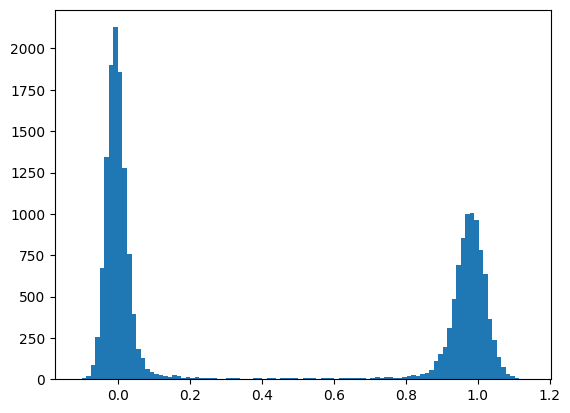

In [6]:
plt.hist((validation_outputs[:,20]), bins=100) # just looking at the outputs from the protected head 

In [7]:
protected_attribute_index = get_all_celeba_attributes().index('Male')
target_attribute_index = get_all_celeba_attributes().index('Wearing_Earrings')

In [8]:
val = np.column_stack((validation_outputs[:,target_attribute_index], validation_outputs[:,20]))
val_target = validation_labels[:,target_attribute_index]
val_groups = validation_labels[:,protected_attribute_index]

test = np.column_stack((test_outputs[:,target_attribute_index], test_outputs[:,20]))
test_target = test_labels[:,target_attribute_index]
test_groups = test_labels[:,protected_attribute_index]

In [9]:
from collections import Counter
Counter(test_target)

Counter({1: 4125, 0: 15837})

In [10]:
#Helper functions.
#We assume that classifiers return multiple scores roughly lying in [0,1].
#To make this happen,we push logits through a sigmoid, and for square outputs we return them, and 1- them
def sigmoid(array):
    return np.stack ((1/(1+np.exp(array[:,0])),1/(1+np.exp(-array[:,0]))),1)
def square_align(array):
    return np.stack((array[:,1],1-array[:,1]),1)

In [11]:
val_dict={'data':val, 'target':val_target, 'groups':val_groups}
test_dict={'data':test,'target':test_target,'groups':test_groups}

### Enforcing Fairness

In [12]:
#fpred=oxonfair.FairPredictor(sigmoid,val_dict,inferred_groups=square_align, use_fast=False)
fpred = oxonfair.DeepFairPredictor(val_target,val,val_groups)

In [13]:
#fpred.fit(gm.accuracy,gm.equal_opportunity,0.05)
fpred.fit(gm.accuracy,gm.recall.min,0.8)
# this can be changed to different definitions of fairness --- fpred.fit(gm.accuracy,gm.equal_opportunity,0.05)


In [14]:
fpred.evaluate(test_dict)

,original,updated
Accuracy,0.910380,0.889991
Balanced Accuracy,0.853250,0.858418
F1 score,0.777072,0.751415
MCC,0.721488,0.683639
Precision,0.799487,0.704821
Recall,0.755879,0.804606
ROC AUC,0.956715,0.941155


In [15]:
fpred.evaluate_groups(return_original=True) #on val

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.924800           0.861855  0.794045  0.749278   
         0                   0.878429           0.852288  0.805169  0.717852   
         1                   0.987349           0.564036  0.207407  0.254912   
         Maximum difference  0.108920           0.288252  0.597762  0.462940   
updated  Overall             0.907082           0.868156  0.767740  0.711025   
         0                   0.877991           0.858793  0.809732  0.719973   
         1                   0.946323           0.885989  0.281646  0.359541   
         Maximum difference  0.068332           0.027196  0.528087  0.360432   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.831169  0.760095  0.965498   
         0                    0.833624  0.778593  0.940365   
         1                    0.518519  0.129630  0.960154   
         Maximum difference   0.315106  0.648963  0.019789   
updated  Overall              0.733590  0.805226  0.948592   
         0                    0.814856  0.804673  0.940317   
         1                    0.169847  0.824074  0.961775   
         Maximum difference   0.645008  0.019401  0.021458   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          19867.0          3789.0   
         0                                11409.0          3681.0   
         1                                 8458.0           108.0   
         Maximum difference                2951.0          3573.0   
updated  Overall                          19867.0          3789.0   
         0                                11409.0          3681.0   
         1                                 8458.0           108.0   
         Maximum difference                2951.0          3573.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                    16078.0             0.190718   
         0                           7728.0             0.322640   
         1                           8350.0             0.012769   
         Maximum difference           622.0             0.309871   
updated  Overall                    16078.0             0.190718   
         0                           7728.0             0.322640   
         1                           8350.0             0.012769   
         Maximum difference           622.0             0.309871   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.174410  
         0                                   0.301341  
         1                                   0.003192  
         Maximum difference                  0.298149  
updated  Overall                             0.209342  
         0                                   0.318608  
         1                                   0.061953  
         Maximum difference                  0.256655

In [16]:
fpred.evaluate_groups(test_dict,return_original=True) #on the test set

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.910380           0.853250  0.777072  0.721488   
         0                   0.866498           0.843349  0.789657  0.692062   
         1                   0.980039           0.633222  0.388889  0.426468   
         Maximum difference  0.113541           0.210128  0.400768  0.265595   
updated  Overall             0.889991           0.858418  0.751415  0.683639   
         0                   0.865436           0.848627  0.793173  0.693547   
         1                   0.928970           0.901967  0.367206  0.429243   
         Maximum difference  0.063533           0.053340  0.425967  0.264305   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.799487  0.755879  0.956715   
         0                    0.801305  0.778341  0.931490   
         1                    0.700000  0.269231  0.969253   
         Maximum difference   0.101305  0.509111  0.037764   
updated  Overall              0.704821  0.804606  0.941155   
         0                    0.785093  0.801420  0.931017   
         1                    0.232456  0.873626  0.967224   
         Maximum difference   0.552637  0.072206  0.036207   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          19962.0          4125.0   
         0                                12247.0          3943.0   
         1                                 7715.0           182.0   
         Maximum difference                4532.0          3761.0   
updated  Overall                          19962.0          4125.0   
         0                                12247.0          3943.0   
         1                                 7715.0           182.0   
         Maximum difference                4532.0          3761.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                    15837.0             0.206643   
         0                           8304.0             0.321956   
         1                           7533.0             0.023590   
         Maximum difference           771.0             0.298366   
updated  Overall                    15837.0             0.206643   
         0                           8304.0             0.321956   
         1                           7533.0             0.023590   
         Maximum difference           771.0             0.298366   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.195371  
         0                                   0.312730  
         1                                   0.009073  
         Maximum difference                  0.303656  
updated  Overall                             0.235898  
         0                                   0.328652  
         1                                   0.088658  
         Maximum difference                  0.239993

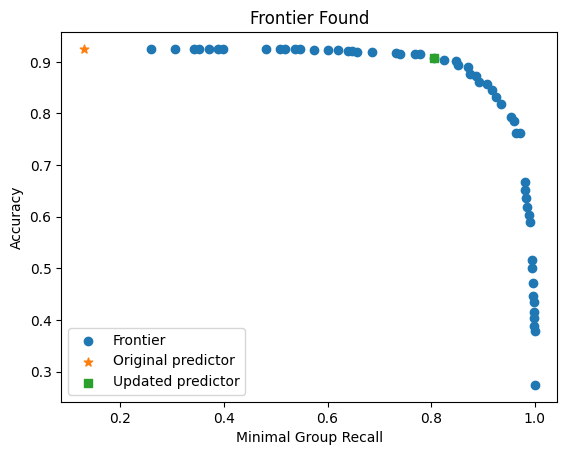

In [17]:
figure = fpred.plot_frontier() #looking at the frontier on the validation set

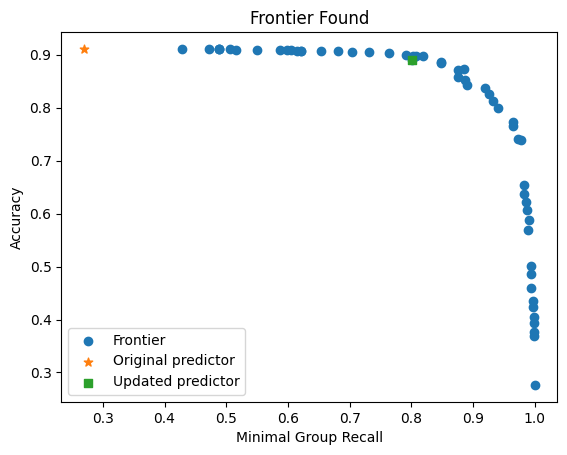

In [18]:
fpred.plot_frontier(test_dict) # viewing performance on the test set. 

In [19]:
fpred.evaluate_fairness(test_dict)

,original,updated
Class Imbalance,0.298366,0.298366
Demographic Parity,0.303656,0.239993
Disparate Impact,0.029013,0.269764
Maximal Group Difference in Accuracy,0.113541,0.063533
Maximal Group Difference in Recall,0.509111,0.072206
Maximal Group Difference in Conditional Acceptance Rate,1.570496,0.713545
Maximal Group Difference in Acceptance Rate,0.101305,0.552637
Maximal Group Difference in Specificity,0.088855,0.034473
Maximal Group Difference in Conditional Rejectance Rate,0.001225,0.061425
Maximal Group Difference in Rejection Rate,0.086440,0.091961


In [20]:
fpred.evaluate(test_dict)

,original,updated
Accuracy,0.910380,0.889991
Balanced Accuracy,0.853250,0.858418
F1 score,0.777072,0.751415
MCC,0.721488,0.683639
Precision,0.799487,0.704821
Recall,0.755879,0.804606
ROC AUC,0.956715,0.941155


### Fitzpatrick-17k Example

In [21]:
fitz_outputs_val = np.load('60_20_20_1_balanced_outputs_val_fitz17k.npy')
fitz_outputs_test = np.load('60_20_20_1_balanced_outputs_test_fitz17k.npy')
fitz_target_labels_val = np.load('60_20_20_1_fitz17k_target_labels_val.npy')
fitz_protected_labels_val = np.load('60_20_20_1_fitz17k_protected_labels_val.npy')
fitz_target_labels_test = np.load('60_20_20_1_fitz17k_target_labels_test.npy')
fitz_protected_labels_test = np.load('60_20_20_1_fitz17k_protected_labels_test.npy')

In [22]:
val_dict_fitz={'data':fitz_outputs_val, 'target':fitz_target_labels_val, 'groups':fitz_protected_labels_val}
test_dict_fitz={'data':fitz_outputs_test,'target':fitz_target_labels_test,'groups':fitz_protected_labels_test}

In [23]:
fpred_fitz = oxonfair.DeepFairPredictor(fitz_target_labels_val,fitz_outputs_val,fitz_protected_labels_val)


In [24]:
fpred_fitz.fit(gm.accuracy,gm.recall.min,0.7)

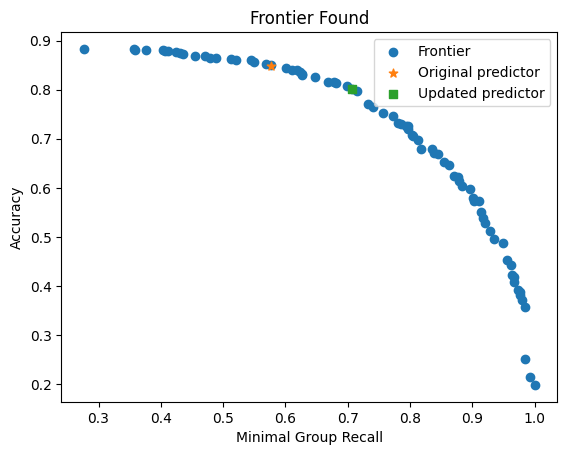

In [25]:
fpred_fitz.plot_frontier() #looking at the frontier on the validation set

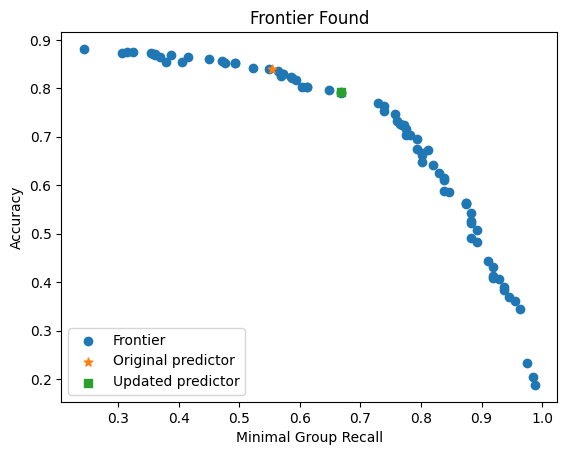

In [26]:
fpred_fitz.plot_frontier(test_dict_fitz) #looking at the frontier on the validation set